#### Goal :: Predict the sale (number of items) for the shop-item pair in the  test set. The test set is for one month - November 2015 

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime, timedelta, date
from calendar import monthrange
from pytz import timezone
import pandas as pd
import numpy as np
import feather
import datetime
import pytz
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline

def get_dates_in_month(year, month, time_zone):
    num_days = monthrange(year, month)[1]
    first_date_of_month = datetime.datetime(year,month,1, tzinfo=time_zone)
    last_date_of_month =  datetime.datetime(year,month,num_days, tzinfo=time_zone)
    return get_dates_inrange(first_date_of_month, last_date_of_month)


def get_dates_inrange(date1, date2):
    if (not isinstance(date1, datetime.datetime)) | (not isinstance(date2, datetime.datetime)):
        return "date1 and date2 should be of type datetime.date"
    num_days = (date2 - date1).days + 1
    date_list = [date1 + datetime.timedelta(days=x) for x in range(0, num_days)]
    return date_list

In [87]:
DATA_FOLDER = './'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
date_df = pd.read_pickle("russian_holidays.pkl")
geography = pd.read_csv('geography.csv')
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
holiday_filepath = 'hol.feather'
holidays = feather.read_dataframe(holiday_filepath)

In [88]:
print(sales.shape)
print(test.shape)
print("\n")
print("Total Items: {}".format(items.item_id.nunique()))
print("Total Categories: {}".format(item_categories.item_category_id.nunique()))
print("Total Shops: {}".format(shops.shop_id.nunique()))
print("\n--------------------------------------------------------\n")

print("Training data")
print("  # unique shops: {}".format(sales.shop_id.nunique()))
print("  # unique items: {}".format(sales.item_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Test data")
print("  # unique shops: {}".format(test.shop_id.nunique()))
print("  # unique items: {}".format(test.item_id.nunique()))


%matplotlib inline
transactions = sales
# Drop the rows with price lt zero. ther is only one.
transactions = transactions[transactions.item_price > 0]

# Merging to get category_id in the transaction df
transactions = pd.merge(transactions, items[['item_id', 'item_category_id']], on='item_id', how='left')

print("\n\n")

items_test_nottrans = len(set(test.item_id.unique()) - set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
intersection_items_test_transac = len(set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
item_count_test = len(set(test.item_id.unique()))

print("# items in test set: {}".format(item_count_test))
print("# items in test set and transaction set: {}".format(intersection_items_test_transac))
print("# items in test but not transaction: {}".format(items_test_nottrans))

print("\n")

shops_test_nottrans = len(set(test.shop_id.unique()) - set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
intersection_shops_test_transac = len(set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
shop_count_test = len(set(test.shop_id.unique()))

print("# shops in test set: {}".format(shop_count_test))
print("# shops in test set and transaction set: {}".format(intersection_shops_test_transac))
print("# shops in test but not transaction: {}".format(shops_test_nottrans))

print("\n")

(2935849, 6)
(214200, 3)


Total Items: 22170
Total Categories: 84
Total Shops: 60

--------------------------------------------------------

Training data
  # unique shops: 60
  # unique items: 21807

--------------------------------------------------------

Test data
  # unique shops: 42
  # unique items: 5100



# items in test set: 5100
# items in test set and transaction set: 4737
# items in test but not transaction: 363


# shops in test set: 42
# shops in test set and transaction set: 42
# shops in test but not transaction: 0




##### Building the shops data frame

In [102]:
# Setting the shop_type
shops_df = shops

shop_types = ['ТЦ', 'ТРК', 'ТРЦ', 'МТРЦ', 'ТК', 'online']
shops_df["shop_type"] = shops_df.shop_name.apply(lambda x: x.split()[1] if x.split()[1] in shop_types else 'OTH')
shops_df.loc[shops_df.shop_id.isin([12, 55]) , 'shop_type'] = "online"
shops_df.loc[shops_df.shop_id == 9 , 'shop_type'] = "outbound"

# Setting the city for each shop
shops_df["city"] = shops_df.shop_name.apply(lambda x: x.split()[0].replace("!", ""))
shops_df.loc[shops_df.city.isin(["Интернет-магазин", "Цифровой", "Выездная"]) , 'city'] = "no_city"

 # Appending the geographic info to shops df
shops_df = pd.merge(shops_df, geography.drop(['city_eng'], axis=1), on='city', how='left')


# Get rid of NaN values from 'time_wrt_utc' and 'dist_from_moscow' columns
# for c in ['time_wrt_utc', 'dist_from_moscow']:
#     shops_df.loc[shops_df[c].isnull(), c] = np.mean(shops_df[c])

# Changing the type to 'category'
catg = ['shop_type', 'city', 'fed_subject', 'fed_dist']
for c in catg:
    shops_df[c] = shops_df[c].astype('category')

print(shops_df.shape)
shops_df

(60, 8)


shop_name  shop_id shop_type  \
0                     !Якутск Орджоникидзе, 56 фран        0       OTH   
1                     !Якутск ТЦ "Центральный" фран        1        ТЦ   
2                                  Адыгея ТЦ "Мега"        2        ТЦ   
3                    Балашиха ТРК "Октябрь-Киномир"        3       ТРК   
4                          Волжский ТЦ "Волга Молл"        4        ТЦ   
5                            Вологда ТРЦ "Мармелад"        5       ТРЦ   
6                        Воронеж (Плехановская, 13)        6       OTH   
7                            Воронеж ТРЦ "Максимир"        7       ТРЦ   
8                      Воронеж ТРЦ Сити-Парк "Град"        8       ТРЦ   
9                                 Выездная Торговля        9  outbound   
10                       Жуковский ул. Чкалова 39м?       10       OTH   
11                       Жуковский ул. Чкалова 39м²       11       OTH   
12                              Интернет-магазин ЧС       12    online   
13                              Казань ТЦ "Бехетле"       13        ТЦ   
14                          Казань ТЦ "ПаркХаус" II       14        ТЦ   
15                             Калуга ТРЦ "XXI век"       15       ТРЦ   
16                                 Коломна ТЦ "Рио"       16        ТЦ   
17                    Красноярск ТЦ "Взлетка Плаза"       17        ТЦ   
18                             Красноярск ТЦ "Июнь"       18        ТЦ   
19                            Курск ТЦ "Пушкинский"       19        ТЦ   
20                              Москва "Распродажа"       20       OTH   
21                           Москва МТРЦ "Афи Молл"       21      МТРЦ   
22                               Москва Магазин С21       22       OTH   
23                 Москва ТК "Буденовский" (пав.А2)       23        ТК   
24                 Москва ТК "Буденовский" (пав.К7)       24        ТК   
25                              Москва ТРК "Атриум"       25       ТРК   
26                      Москва ТЦ "Ареал" (Беляево)       26        ТЦ   
27                   Москва ТЦ "МЕГА Белая Дача II"       27        ТЦ   
28                  Москва ТЦ "МЕГА Теплый Стан" II       28        ТЦ   
29               Москва ТЦ "Новый век" (Новокосино)       29        ТЦ   
30                           Москва ТЦ "Перловский"       30        ТЦ   
31                          Москва ТЦ "Семеновский"       31        ТЦ   
32                       Москва ТЦ "Серебряный Дом"       32        ТЦ   
33                                Мытищи ТРК "XL-3"       33       ТРК   
34                             Н.Новгород ТРЦ "РИО"       34       ТРЦ   
35                      Н.Новгород ТРЦ "Фантастика"       35       ТРЦ   
36            Новосибирск ТРЦ "Галерея Новосибирск"       36       ТРЦ   
37                            Новосибирск ТЦ "Мега"       37        ТЦ   
38                                   Омск ТЦ "Мега"       38        ТЦ   
39            РостовНаДону ТРК "Мегацентр Горизонт"       39       ТРК   
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40       ТРК   
41                           РостовНаДону ТЦ "Мега"       41        ТЦ   
42                           СПб ТК "Невский Центр"       42        ТК   
43                                  СПб ТК "Сенная"       43        ТК   
44                              Самара ТЦ "Мелодия"       44        ТЦ   
45                             Самара ТЦ "ПаркХаус"       45        ТЦ   
46                            Сергиев Посад ТЦ "7Я"       46       OTH   
47                           Сургут ТРЦ "Сити Молл"       47       ТРЦ   
48                     Томск ТРЦ "Изумрудный Город"       48       ТРЦ   
49                            Тюмень ТРЦ "Кристалл"       49       ТРЦ   
50                               Тюмень ТЦ "Гудвин"       50        ТЦ   
51                        Тюмень ТЦ "Зеленый Берег"       51        ТЦ   
52                             Уфа ТК "Центральный"       52        ТК   
53                                 Уфа ТЦ "Сем

### These are entries for Online - 'shops'

Выездная Торговля	9	OTH	Выездная	-1	NaN	NaN	-1          (exit trade)

Интернет-магазин ЧС	12	OTH	Интернет-магазин	-1	NaN	NaN	-1   (Online shop Emergency)

Цифровой склад 1С-Онлайн	55	OTH	Цифровой	-1	NaN	NaN	-1 (Digital warehouse 1C-Online)

#### Building a date df, and block_num_info df for adding temporal data.

In [63]:
# setting up the calendar and the Block_num info dataframe

moscow = timezone('Europe/Moscow')
train_first_date = datetime.datetime(2013,1,1, tzinfo=moscow)
train_last_date =  datetime.datetime(2015,11,30, tzinfo=moscow)

date_df = pd.DataFrame(get_dates_inrange(train_first_date, train_last_date), columns=['date'])

date_df['weekday'] = date_df['date'].apply(lambda x: x.isoweekday())
date_df['is_weekend'] = date_df['weekday'] > 5

# Holidays dataframe - (preparing df)
holidays_b = holidays
holidays_b['date_str'] = holidays_b.date.apply(lambda x: x.isoformat().split("T")[0])
holidays_b['off_day'] =  holidays_b.h_type.apply(lambda x: x.split(",")[0] == 'National holiday')
holidays_b['is_holiday'] = True

date_df['date_str'] = date_df.date.apply(lambda x: x.isoformat().split("T")[0])

date_df = pd.merge(date_df, holidays_b[['date_str', 'is_holiday']], on='date_str', how='left')
date_df['is_holiday'].fillna(False, inplace=True)

date_df = pd.merge(date_df, holidays_b[['off_day', 'date_str']], on='date_str', how='left')
date_df.loc[date_df.loc[:, 'weekday'] > 5, 'off_day'] = True


def add_date_block_num(d):
    if(d.year == 2013):
        base=0
    elif(d.year == 2014):
        base=12
    elif(d.year == 2015): 
        base=24
    return base + (d.month-1)

date_df['date_block_num'] = date_df['date'].apply(lambda x: add_date_block_num(x))

date_df.head()


# Block info df
block_num_info = date_df[date_df.is_weekend == True].groupby('date_block_num')['is_weekend'].sum().reset_index(name = "weekends")

block_num_info['holidays'] = date_df[date_df.is_holiday == True].groupby('date_block_num')['is_holiday'].sum()
block_num_info['holidays'].fillna(0, inplace=True)

block_num_info['off_days'] = date_df[date_df.off_day == True].groupby('date_block_num')['off_day'].sum()
block_num_info['off_days'].fillna(0, inplace=True)

block_num_info.head()

date_block_num  weekends  holidays  off_days
0               0       8.0       7.0        14
1               1       8.0       2.0         8
2               2      10.0       2.0        11
3               3       8.0       0.0         8
4               4       8.0       9.0        16

#### Build the initial training df

In [64]:
# 'sales' is the input training dataframe
sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

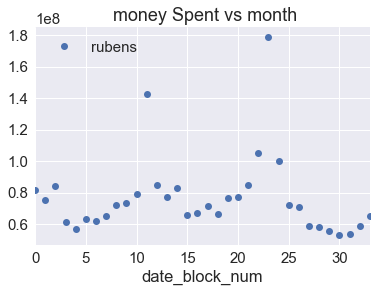

In [65]:
# Money spent every month ( We see the seasonality!)
plt.clf()
total_transactions_monthly = sales[sales['item_cnt_day'] > 0].groupby('date_block_num')['item_price'].sum().reset_index(name = "rubens")
sns.set_style("darkgrid")
total_transactions_monthly.plot(x='date_block_num', y='rubens', style='o')
plt.title(" money Spent vs month")
plt.show()

In [66]:

# remove date column
sales_monthly = sales.drop(['date'], axis=1)

# Aggregating item_cnt_day (summing) and item_price(averaging)
agg_funcs = {'item_cnt_day':np.sum, 'item_price':np.mean}
sales_monthly = sales_monthly.groupby(['date_block_num', 'shop_id', 'item_id']).agg(agg_funcs).reset_index()

# rename the columns
sales_monthly.rename(columns={'item_price':'item_avg_price', 'item_cnt_day':'item_cnt_month'}, inplace=True)

# Adding seasonality - month numbers (jan1, feb-2, march-3....dec-12)
sales_monthly['month'] = (sales_monthly['date_block_num'] % 12)+1

# Appending shop information
sales_monthly = pd.merge(sales_monthly, shops_df, on='shop_id', how='left')

# Appending block_num_info (temporal features)
sales_monthly = pd.merge(sales_monthly, block_num_info, on='date_block_num', how='left')

# Appending item info
sales_monthly = pd.merge(sales_monthly, items, on='item_id', how='left')

print(sales_monthly.shape)

(1609124, 18)


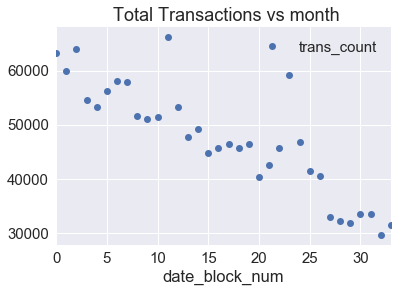

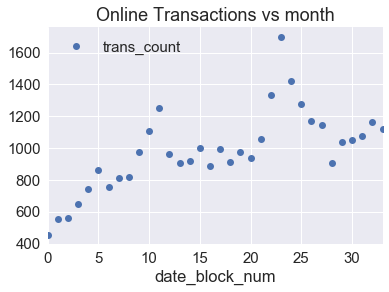

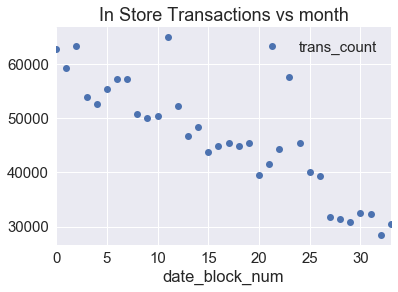

In [70]:
# Online vs In-store sales

phy_stores_list = list(set(shops_df.shop_id) ^ set([12,55]))

plt.clf()
total_transactions_monthly = sales_monthly.groupby('date_block_num').size().reset_index(name = "trans_count")
sns.set_style("darkgrid")
total_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
plt.title(" Total Transactions vs month")
plt.show()

plt.clf()
online_transactions_monthly = sales_monthly[sales_monthly['shop_id'].isin([12,55])].groupby('date_block_num').size().reset_index(name = "trans_count")
sns.set_style("darkgrid")
online_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
plt.title("Online Transactions vs month")
plt.show()

plt.clf()
instore_transactions_monthly = sales_monthly[sales_monthly['shop_id'].isin(phy_stores_list)].groupby('date_block_num').size().reset_index(name = "trans_count")
sns.set_style("darkgrid")
instore_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
plt.title("In Store Transactions vs month")
plt.show()

### Observation:
1. In-store transactions are decreasing every month !!

2. Online sales are increasing !!

3. The total transactions are decreasing every month.... this is surprising !!

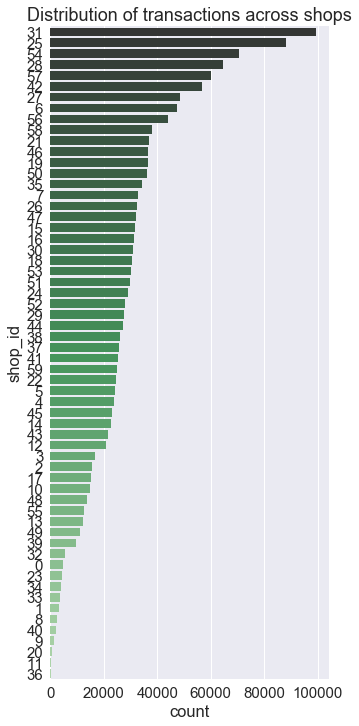

In [27]:
plt.clf()

# Plot the shopi-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(5, 12))
sns.set(font_scale=1.5)

sns.countplot(y="shop_id", data=sales_monthly, palette="Greens_d", order = sales_monthly['shop_id'].value_counts().index)

plt.title("Distribution of transactions across shops")
plt.show()


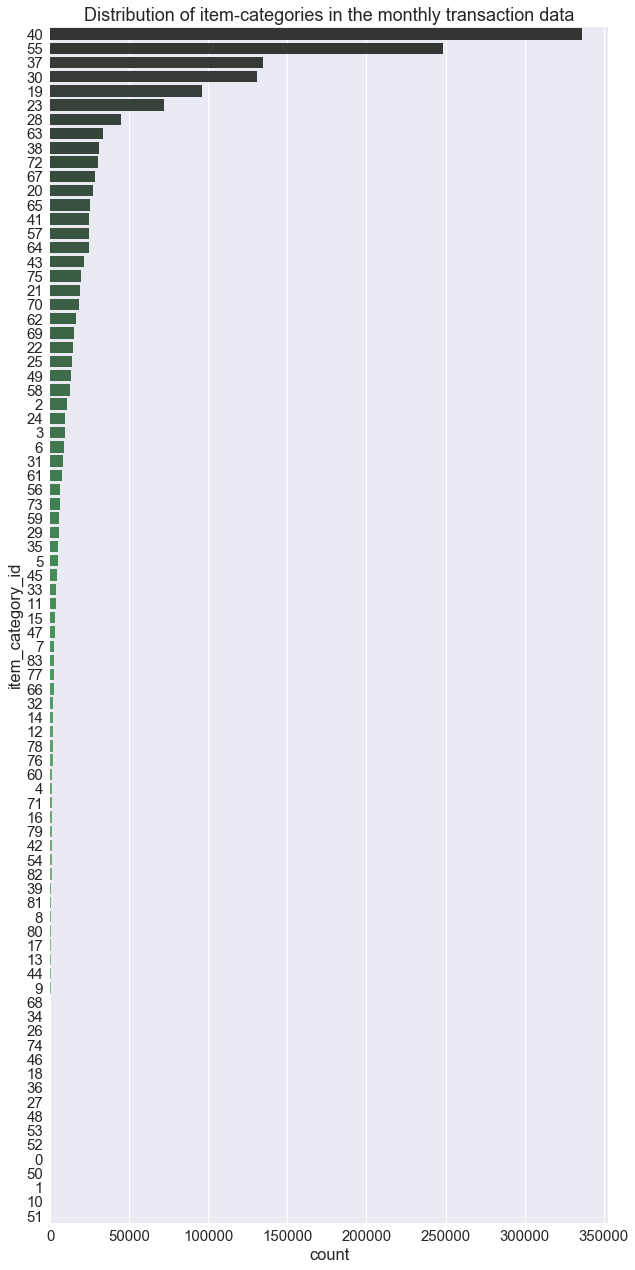

In [21]:
plt.clf()

# Plot the shopid-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(10, 22))
sns.set(font_scale=1.5)

sns.countplot(y="item_category_id", data=sales_monthly, palette="Greens_d",
              order = sales_monthly['item_category_id'].value_counts().index)

plt.title("Distribution of item-categories in the monthly transaction data")
plt.show()


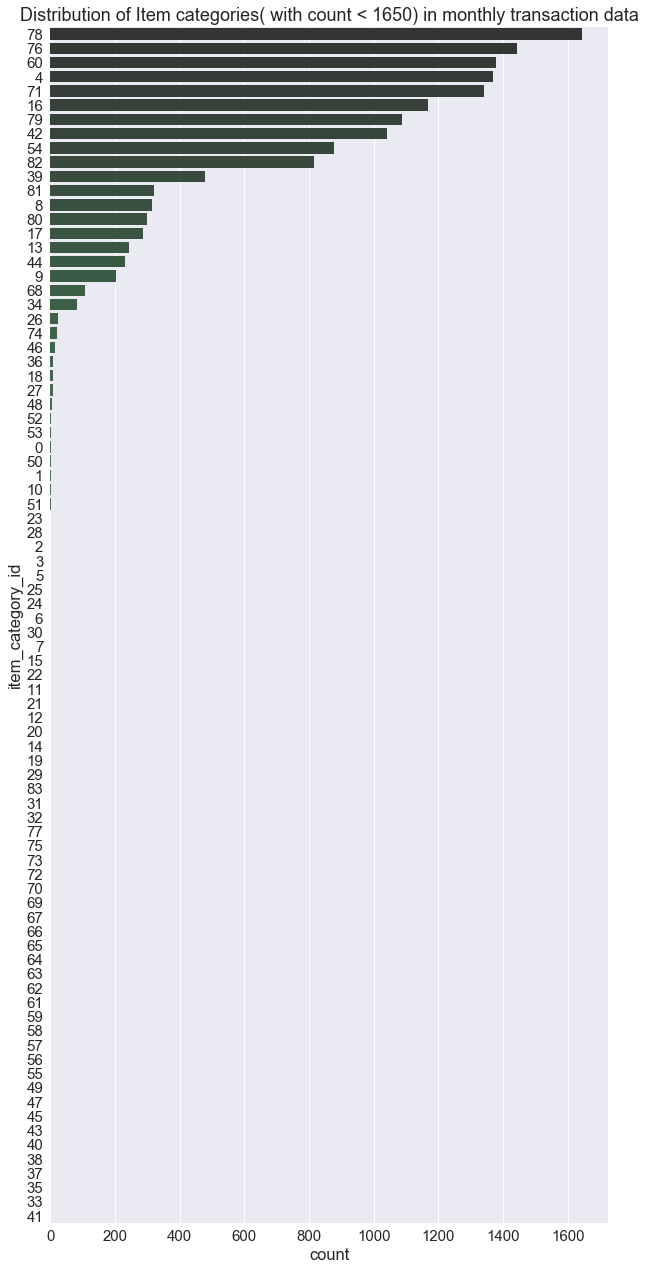

In [22]:
item_catgs = [51, 10, 1, 50, 0, 52, 53, 48, 27, 36, 18, 46, 74, 26, 34, 68, 9, 44, 13,
              17, 80, 8, 81, 39, 82, 54, 42, 79, 16, 71, 4, 60, 76, 78]

plt.clf()

# Plot the shopi-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(10, 22))
sns.set(font_scale=1.5)
df = sales_monthly[sales_monthly['item_category_id'].isin(item_catgs)]

sns.countplot(y="item_category_id", data=sales_monthly[sales_monthly['item_category_id'].isin(item_catgs)],
              palette="Greens_d", order = df['item_category_id'].value_counts().index)
plt.title("Distribution of Item categories( with count < 1650) in monthly transaction data")
plt.show()

In [14]:
# Feature  List

numeric_var = list(["item_avg_price", "dist_from_moscow", "holidays", "off_days"])
categ_var = list(['shop_id' , 'shop_type', 'time_wrt_utc',  "weekends", 'city', 'fed_subject', 'fed_dist', 'item_category_id', 'item_id'])
text_var  = list(['item_name', 'shop_name'])
temporal_var = list(['date_block_num', 'month' ])
target_var = 'item_cnt_month'

sales_monthly[categ_var] = sales_monthly[categ_var].apply(lambda x: x.astype('category'))
sales_monthly[numeric_var] = sales_monthly[numeric_var].apply(lambda x: pd.to_numeric(x, downcast='float'))
sales_monthly[text_var] = sales_monthly[text_var].apply(lambda x: x.astype('str'))
sales_monthly[temporal_var] = sales_monthly[temporal_var].apply(lambda x: x.astype('int'))

sales_monthly.head(4)

date_block_num shop_id item_id  item_avg_price  item_cnt_month  month  \
0               0       0      32           221.0             6.0      1   
1               0       0      33           347.0             3.0      1   
2               0       0      35           247.0             1.0      1   
3               0       0      43           221.0             1.0      1   

                       shop_name shop_type    city time_wrt_utc  \
0  !Якутск Орджоникидзе, 56 фран       OTH  Якутск            9   
1  !Якутск Орджоникидзе, 56 фран       OTH  Якутск            9   
2  !Якутск Орджоникидзе, 56 фран       OTH  Якутск            9   
3  !Якутск Орджоникидзе, 56 фран       OTH  Якутск            9   

      fed_subject  fed_dist  dist_from_moscow weekends  holidays  off_days  \
0  Sakha Republic  Far East            8395.0      8.0       7.0      14.0   
1  Sakha Republic  Far East            8395.0      8.0       7.0      14.0   
2  Sakha Republic  Far East            8395.0      8.0       7.0      14.0   
3  Sakha Republic  Far East            8395.0      8.0       7.0      14.0   

            item_name item_category_id  
0                 1+1               40  
1            1+1 (BD)               37  
2       10 ЛЕТ СПУСТЯ               40  
3  100 МИЛЛИОНОВ ЕВРО               40

#### To Do:

For training:

1. replace Item id by item tf-idf dtm features --- INCOMPLETE
2. Handle categorical features - statistical target encoding, label encoding etc (some encoding!)
3. get rid of temporal features month, block_num - DONE -- see the train-validation set [17]
4. get rid of shop name - DONE
5. scale the training features.

For test dataset:

1. calculate avg. price for the items in test data set
2. Append shop features
3. Append item tf-idf dtm features

In [130]:
len(sales_monthly[sales_monthly['shop_id'].isin([12])])

20742

In [15]:
# Single Train-Validation set
b = 12 # Training on: blocks[0:11], Validation on: block# 12

x_train = sales_monthly[sales_monthly['date_block_num'] < b][numeric_var + categ_var + text_var]
y_train = sales_monthly[sales_monthly['date_block_num'] < b][target_var]

x_val = sales_monthly[sales_monthly['date_block_num'] == b][numeric_var + categ_var + text_var]
y_val = sales_monthly[sales_monthly['date_block_num'] == b][target_var]

In [16]:

a = set(list(x_train.shop_id.unique()))
b = set(list(x_val.shop_id.unique()))

In [17]:
print(a)
print(len(a))
print(b)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 38, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}
52
{2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 35, 37, 38, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}


In [19]:
a ^ b

{0, 1, 8, 9, 23, 32}